In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#######
IN_DATA_FNAME = '/data/delon/LensQuEst/map_sims_800x800_20x20.pkl'
DATA_FNAME = '/data/delon/LensQuEst/QE_and_Nhat_from_map_sims_800x800_20x20.pkl'

import warnings
warnings.filterwarnings("ignore")
#####

In [3]:
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

#to get latex to work, shoulldn't be necessary for most ppl
os.environ['PATH'] = "%s:/usr/local/cuda-11.2/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/anaconda/bin:/home/delon/texlive/bin/x86_64-linux:/home/delon/.local/bin:/home/delon/bin"%os.environ['PATH']

In [4]:
from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr
import matplotlib

In [5]:
print("Map properties")

# number of pixels for the flat map
nX = 800
nY =800

# map dimensions in degrees
sizeX = 20.
sizeY = 20.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 21  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra

Map properties


In [ ]:
#### print("CMB experiment properties")

# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S3 specs
cmb = StageIVCMB(beam=1.4, noise=7., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: cmb.ftotal(l) 

# reinterpolate: gain factor 10 in speed
L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

In [7]:
print("CMB lensing power spectrum")
u = UnivPlanck15()
halofit = Halofit(u, save=False)
w_cmblens = WeightLensSingle(u, z_source=1100., name="cmblens")
p2d_cmblens = P2dAuto(u, halofit, w_cmblens, save=False)

CMB lensing power spectrum


In [8]:
print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(cmb.funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)
Ntheory = lambda l: fNqCmb_fft(l) 

Gets a theoretical prediction for the noise
computing the reconstruction noise


In [9]:
f = open(IN_DATA_FNAME, 'rb') 
in_data = pickle.load(f) 
f.close()
for key in in_data:
    print(key, np.shape(in_data[key]))

cmb0F_1 (100, 800, 401)
kCmbF_1 (100, 800, 401)
lCmbF_1 (100, 800, 401)
lCmbF_o1_1 (100, 800, 401)
lCmbF_o2_1 (100, 800, 401)
lCmbF_o3_1 (100, 800, 401)
lCmbF_o4_1 (100, 800, 401)
fgF_1 (100, 800, 401)
noiseF_1 (100, 800, 401)
totalF_1 (100, 800, 401)
totalF_0 (100, 800, 401)


In [10]:
pairs = [
    [0,0], #N0
    [0,1], #kappa
    [1,0], #kappa
    [1,1], #N1
    [0,2], #N1
    [2,0], #N1
    [-1, -1], #QE
    [-2, -2], #unlensed
]

data_names = {
    0: 'cmb0F_1',
    1: 'lCmbF_o1_1',
    2: 'lCmbF_o2_1',
    -1: 'lCmbF_1',
    -2: 'totalF_0',
}

In [11]:
f = open(DATA_FNAME, 'rb') 
data = pickle.load(f) 
f.close()
for key in data:
    print(key, np.shape(data[key]))

00 (100, 800, 401)
00_sqrtN (100, 800, 401)
01 (100, 800, 401)
01_sqrtN (0,)
10 (100, 800, 401)
10_sqrtN (0,)
11 (100, 800, 401)
11_sqrtN (100, 800, 401)
02 (100, 800, 401)
02_sqrtN (0,)
20 (100, 800, 401)
20_sqrtN (0,)
-1-1 (100, 800, 401)
-1-1_sqrtN (100, 800, 401)
-2-2 (100, 800, 401)
-2-2_sqrtN (100, 800, 401)


In [12]:
ps_data = {}

In [13]:
#estimate N0
ck = 'N0'

for data_idx in range(len(data['00'])):
    q00 = data['00'][data_idx]
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=q00)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((np.array([c_ps_data[ck]]), ps_data[ck]))  

In [14]:
#estimate kk
ck = 'kk'


for data_idx in range(min(len(data['01']), len(data['10']))):
    q01 = data['01'][data_idx]
    q10 = data['10'][data_idx]
    kCmbFourier = in_data['kCmbF_1'][data_idx]
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.crossPowerSpectrum(dataFourier1=q10+q01, dataFourier2=kCmbFourier)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((np.array([c_ps_data[ck]]), ps_data[ck]))  

In [15]:
#estimate N1
ck = 'N1'

for data_idx in range(min(len(data['00']), len(data['02']),len(data['20']),len(data['11']))):
    q02 = data['02'][data_idx]
    q20 = data['20'][data_idx]
    q00 = data['00'][data_idx]
    q11 = data['11'][data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.crossPowerSpectrum(dataFourier1=q00, 
                                                                                      dataFourier2=2*(q11+q02+q20))
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((np.array([c_ps_data[ck]]), ps_data[ck]))  

In [16]:
#estimate <QE QE>
ck = 'QEQE'
for data_idx in range(len(data['-1-1'])):
    QE = data['-1-1'][data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=QE)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((np.array([c_ps_data[ck]]), ps_data[ck]))  

In [17]:
#estimate <QE QE>
ck = 'Nhat'
for data_idx in range(len(data['-1-1_sqrtN'])):
    sqrtNhat = data['-1-1_sqrtN'][data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=sqrtNhat)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((np.array([c_ps_data[ck]]), ps_data[ck]))  

In [18]:
def combine_Cl(Cls_tot):
    n_runs = np.shape(Cls_tot)[0]
    print(n_runs, np.shape(Cls_tot))
    lCen = Cls_tot[0][0]
    Cls = np.sum(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)/n_runs
    sCls = np.sqrt(np.sum(np.square(np.transpose(Cls_tot, axes=[1,2,0])[2]), axis=1))/n_runs
    return lCen, Cls, sCls

def combine_sketchy(Cl0, Cli):
    n_runs = np.shape(Cl0)[0]
    print(n_runs, np.shape(Cl0))
    ret = np.copy(Cl0)
    ret = np.transpose(ret, axes=[1,2,0])
    ret[1] = np.array([
        [Cl0[run_idx][1][bin_idx]+
         sum([Cli[i][run_idx][1][bin_idx] for i in range(len(Cli))]) 
                     for run_idx in range(n_runs)] 
                    for bin_idx in range(len(Cl0[0][1]))])
    ret[2] = np.array([[np.sqrt(Cl0[run_idx][2][bin_idx]**2+sum([Cli[i][run_idx][2][bin_idx]**2 
                                                               for i in range(len(Cli))]))
                     for run_idx in range(n_runs)] 
                    for bin_idx in range(len(Cl0[0][1]))])
    return np.transpose(ret, axes=[2,0,1])

In [19]:
ps_data['N2+'] = combine_sketchy(ps_data['QEQE'], [-ps_data['N0'], -ps_data['kk'], -ps_data['N1']])
ps_data['N1+'] = combine_sketchy(ps_data['QEQE'], [-ps_data['N0'], -ps_data['kk']])
ps_data['KK+N1+'] = combine_sketchy(ps_data['kk'], [ps_data['N1+']])


100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)


In [20]:
ps_data['QEQE-Nhat'] = combine_sketchy(ps_data['QEQE'], [-ps_data['Nhat']])

100 (100, 3, 50)


100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)


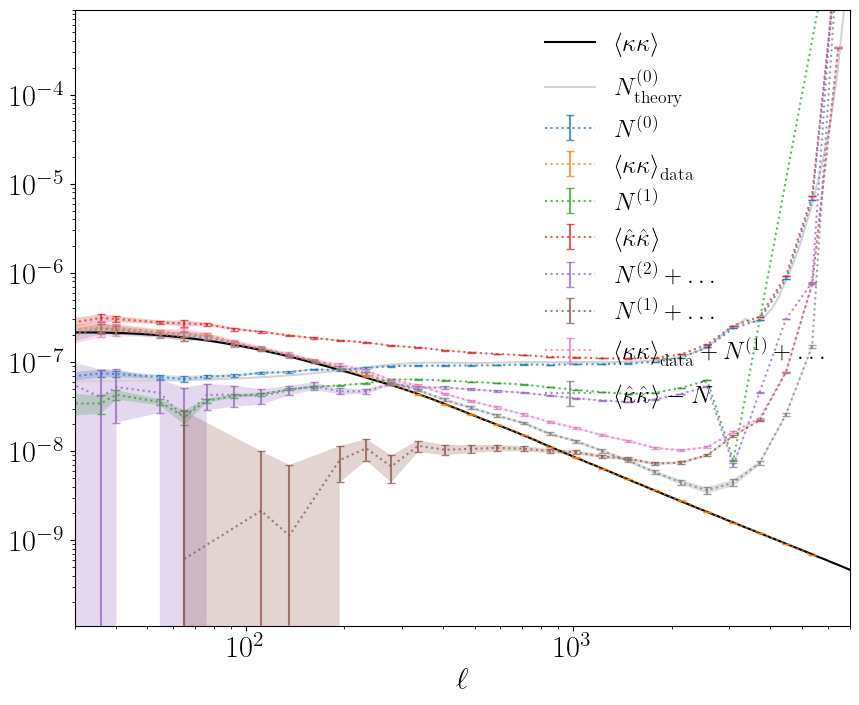

In [21]:
labels={
    'N0':r'$N^{(0)}$',
    'kk':r'$\left<\kappa\kappa\right>_{\rm data}$',
    'N1':r'$N^{(1)}$',
    'N2+':r'$N^{(2)}+\dots$',
    'QEQE':r'$\left<\hat\kappa\hat\kappa\right>$',
    'QEQE-Nhat':r'$\left<\hat\kappa\hat\kappa\right>-\hat N$',
    'Nhat':r'$\hat N$',
    'N1+':r'$N^{(1)}+\dots$',
    'KK+N1+': r'$\left<\kappa\kappa\right>_{\rm data}+N^{(1)}+\dots$',
}



fig,ax = plt.subplots(nrows=1, figsize=(10,8))

ell = baseMap.l.flatten()
theory=[p2d_cmblens.fPinterp, Ntheory]
theory_l=[r'$\big<\kappa\kappa\big>$', r'$N^{(0)}_{\rm theory}$']
theory_s=['black', 'lightgrey']
for f,l,sty in zip(theory, theory_l, theory_s):
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))
    ax.plot(L, ClExpected, sty, label=l)

    


for key in ps_data:
    lCen, Cl, sCl = combine_Cl(np.array(ps_data[key]))
    if(key=='Nhat'):
        continue
    if(key=='N2+'):
        Cl = np.abs(Cl)
#     if(key=='N2+'):
#         print(Cl)


    Ipos = np.where(Cl>=1e-30)
    
    ax.errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=.75, 
                fmt=':', capsize=3, capthick=1, label=labels[key])
    tmp_data = {
        'x': lCen[Ipos],
        'y1': [y - e for y, e in zip((Cl[Ipos]), sCl[Ipos])],
        'y2': [y + e for y, e in zip((Cl[Ipos]), sCl[Ipos])]}
    ax.fill_between(**tmp_data,  alpha=.25)


ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_yscale('log')
ax.set_xlim(lMin,2*lMax)
ax.set_ylim(1.1e-10,.9e-3)

plt.savefig('figures/Ni_decomposed.pdf', bbox_inches='tight')

In [22]:
def graph_from_keys(c_keys, offset=0.03):
    
    
    offsets = dict(zip(c_keys,[i*offset for i in range(len(c_keys))]))
    colors = dict(zip(c_keys,[plt.colormaps["rainbow"](i/len(c_keys)) for i in range(len(c_keys))] ))
    
    fig,ax = plt.subplots(nrows=1, figsize=(10,8))

    ell = baseMap.l.flatten()
    theory=[p2d_cmblens.fPinterp, Ntheory]
    theory_l=[r'$\big<\kappa\kappa\big>$', r'$N^{(0)}_{\rm theory}$']
    theory_s=['black', 'lightgrey']
    for f,l,sty in zip(theory, theory_l, theory_s):
        L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
        ClExpected = np.array(list(map(f, L)))
        ax.plot(L, ClExpected, sty, label=l)

    for key in c_keys:
        lCen, Cl, sCl = combine_Cl(np.array(ps_data[key]))
    
        offset = offsets[key]
        tmp = [l*np.exp(offset)-l for l in lCen]
        lCen += tmp

        Ipos = np.where(Cl>=1e-30)
        Ineg = np.where(Cl<=-1e-30)

        ax.errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=.75, 
                    fmt=':', capsize=3, capthick=1, label=labels[key], c=colors[key])
        tmp_data = {
            'x': lCen[Ipos],
            'y1': [y - e for y, e in zip((Cl[Ipos]), sCl[Ipos])],
            'y2': [y + e for y, e in zip((Cl[Ipos]), sCl[Ipos])]}
        ax.fill_between(**tmp_data,  alpha=.25, color=colors[key])

        
        ax.errorbar(lCen[Ineg], -(Cl[Ineg]), yerr=sCl[Ineg], alpha=.75, 
                    fmt='--', capsize=3, capthick=1, c=colors[key])
        tmp_data = {
            'x': lCen[Ineg],
            'y1': [y - e for y, e in zip(-(Cl[Ineg]), sCl[Ineg])],
            'y2': [y + e for y, e in zip(-(Cl[Ineg]), sCl[Ineg])]}
        ax.fill_between(**tmp_data,  alpha=.25, color=colors[key])

        print(lCen[Ineg])
        print('###########')
        print(lCen[Ipos])

    ax.legend(frameon=False)
    ax.set_xscale('log')
    ax.set_xlabel(r'$\ell$')
    ax.set_yscale('log')
    ax.set_xlim(lMin,2*lMax)
    ax.set_ylim(1.1e-10,.9e-3)
    return fig, ax

100 (100, 3, 50)
[]
###########
[  18.           25.45584412   36.           40.24922359   54.61192978
   64.89992296   75.96865066   92.32408474  111.39271212  135.79670487
  161.11271595  193.60468515  233.43749893  278.21785011  336.08172111
  406.00745995  487.72015463  587.02572641  705.86843938  848.63650578
 1020.92252165 1227.75429979 1476.87984706 1776.22062314 2135.75670246
 2568.7590137  3089.27265454 3715.2199296  4468.8262178  5375.02335138
 6464.45902599]
100 (100, 3, 50)
[6464.45902599]
###########
[  18.           25.45584412   36.           40.24922359   54.61192978
   64.89992296   75.96865066   92.32408474  111.39271212  135.79670487
  161.11271595  193.60468515  233.43749893  278.21785011  336.08172111
  406.00745995  487.72015463  587.02572641  705.86843938  848.63650578
 1020.92252165 1227.75429979 1476.87984706 1776.22062314 2135.75670246
 2568.7590137  3089.27265454 3715.2199296  4468.8262178  5375.02335138]
100 (100, 3, 50)
[ 18.          25.45584412  36.      

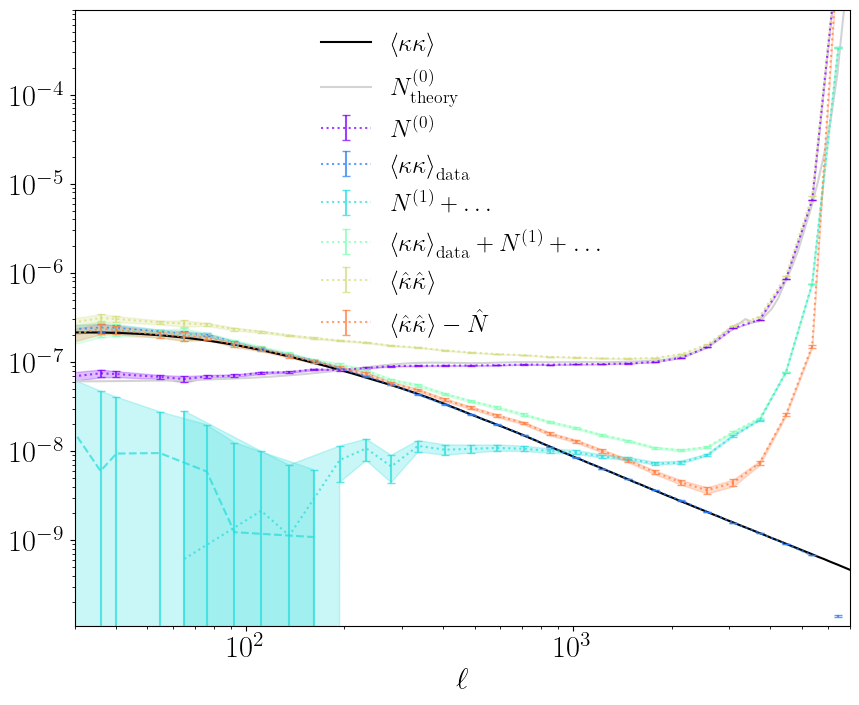

In [23]:
graph_from_keys([
    'N0',
    'kk',
    'N1+',
    'KK+N1+',
    'QEQE',
    'QEQE-Nhat',
], offset=0)
plt.savefig('figures/Ni_decomposed_cleaner.pdf', bbox_inches='tight')

100 (100, 3, 50)
[]
###########
[  18.           25.45584412   36.           40.24922359   54.61192978
   64.89992296   75.96865066   92.32408474  111.39271212  135.79670487
  161.11271595  193.60468515  233.43749893  278.21785011  336.08172111
  406.00745995  487.72015463  587.02572641  705.86843938  848.63650578
 1020.92252165 1227.75429979 1476.87984706 1776.22062314 2135.75670246
 2568.7590137  3089.27265454 3715.2199296  4468.8262178  5375.02335138
 6464.45902599]
100 (100, 3, 50)
[3752.55851065 4513.73866796 5429.04323414]
###########
[  18.18090301   25.71167961   36.36180602   40.65373502   55.1607888
   65.55217803   76.73214829   93.25195722  112.51222748  137.16148445
  162.73192566  195.55044458  235.78358479  281.01398599  339.45939856
  410.08790276  492.62182367  592.92543304  712.96253513  857.16544446
 1031.18296357 1240.09343564 1491.72273629 1794.07193718 2157.22141417
 2594.57547099 3120.32036088 6529.42791931]
100 (100, 3, 50)
[  18.36362412   25.97008629   36.7272

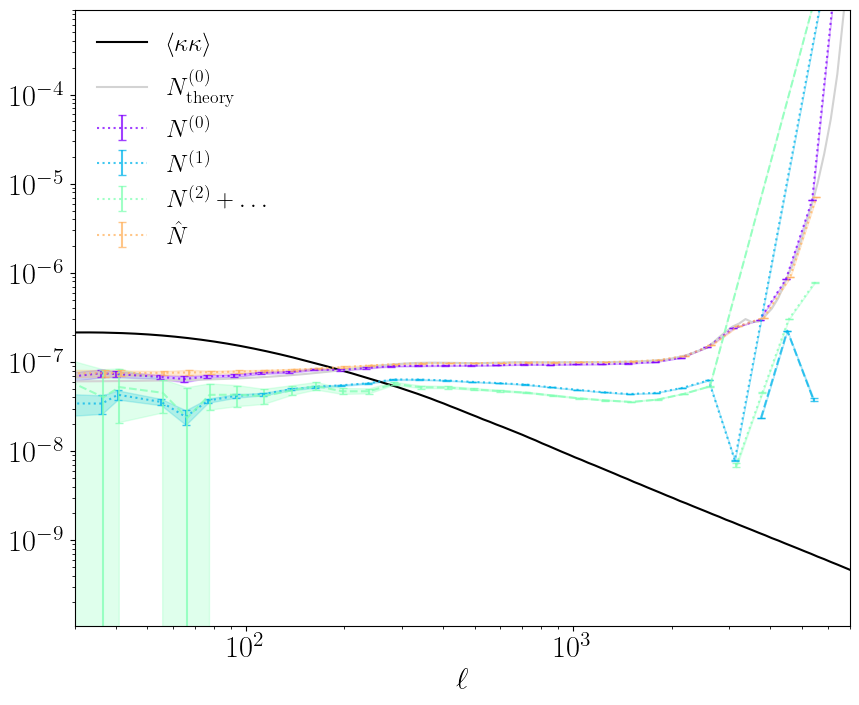

In [24]:
graph_from_keys([
    'N0',
    'N1',
    'N2+',
    'Nhat'
], offset=0.01)
plt.savefig('figures/Ni_decomposed_just_N.pdf', bbox_inches='tight')

100 (100, 3, 50)
100 (100, 3, 50)


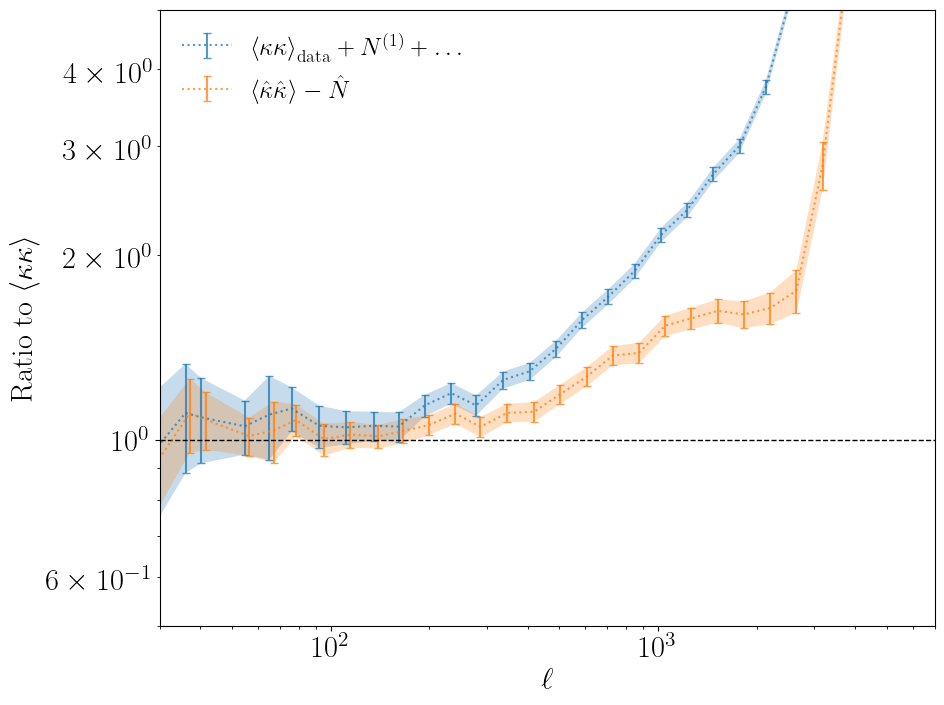

In [25]:
fig,ax = plt.subplots(nrows=1, figsize=(10,8))

c_keys = [
    'KK+N1+',
    'QEQE-Nhat'
]

offsets = dict(zip(c_keys,[0,0.03]))
for key in c_keys:
    lCen, Cl, sCl = combine_Cl(np.array(ps_data[key]))
    
    kk_true = np.array([p2d_cmblens.fPinterp(l) for l in lCen])
    
    Cl /= kk_true
    sCl /= kk_true
    offset = offsets[key]
    tmp = [l*np.exp(offset)-l for l in lCen]
    lCen += tmp

    Ipos = np.where(Cl>=1e-30)
    
    ax.errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=.75, 
                fmt=':', capsize=3, capthick=1, label=labels[key])
    tmp_data = {
        'x': lCen[Ipos],
        'y1': [y - e for y, e in zip((Cl[Ipos]), sCl[Ipos])],
        'y2': [y + e for y, e in zip((Cl[Ipos]), sCl[Ipos])]}
    ax.fill_between(**tmp_data,  alpha=.25)


ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel(r'Ratio to $\left<\kappa\kappa\right>$')

ax.set_xlabel(r'$\ell$')
ax.set_xlim(lMin,2*lMax)
ax.set_ylim(0.5,5)
plt.axhline(1, linewidth=1, linestyle="--", color="black")
plt.savefig('figures/Ni_decomposed_ratios.pdf', bbox_inches='tight')

100 (100, 3, 50)
100 (100, 3, 50)


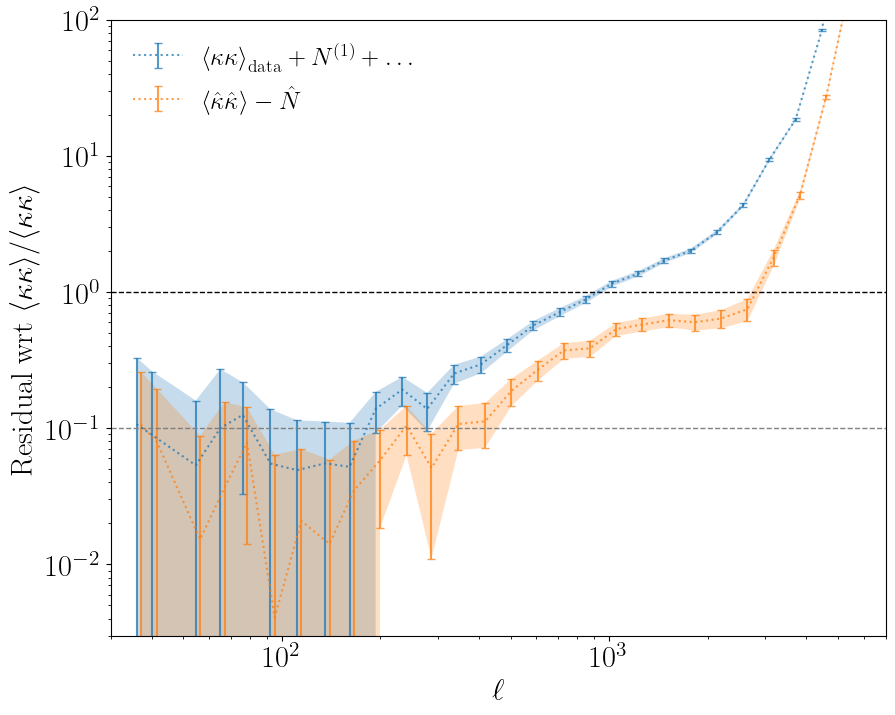

In [26]:
fig,ax = plt.subplots(nrows=1, figsize=(10,8))

c_keys = [
    'KK+N1+',
    'QEQE-Nhat'
]

offsets = dict(zip(c_keys,[0,0.03]))
for key in c_keys:
    lCen, Cl, sCl = combine_Cl(np.array(ps_data[key]))
    
    kk_true = np.array([p2d_cmblens.fPinterp(l) for l in lCen])
    
    Cl -= kk_true
    Cl /= kk_true
    sCl /= kk_true
    
    offset = offsets[key]
    tmp = [l*np.exp(offset)-l for l in lCen]
    lCen += tmp

    Ipos = np.where(Cl>=1e-30)
    Ineg = np.where(Cl<=-1e-30)
    
    ax.errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=.75, 
                fmt=':', capsize=3, capthick=1, label=labels[key])
        
    tmp_data = {
        'x': lCen[Ipos],
        'y1': [y - e for y, e in zip((Cl[Ipos]), sCl[Ipos])],
        'y2': [y + e for y, e in zip((Cl[Ipos]), sCl[Ipos])]}
    ax.fill_between(**tmp_data,  alpha=.25)
    


ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_ylabel(r'Residual wrt $\left<\kappa\kappa\right>$/$\left<\kappa\kappa\right>$')

# ax.set_yscale(matplotlib.scale.SymmetricalLogScale(ax, linthresh=1e-10))
ax.set_yscale('log')


ax.set_xlabel(r'$\ell$')
ax.set_xlim(lMin,2*lMax)
ax.set_ylim(.3e-2,1e2)
plt.axhline(1, linewidth=1, linestyle="--", color="black")
plt.axhline(.1, linewidth=1, linestyle="--", color="gray")

plt.savefig('figures/Ni_decomposed_residual.pdf', bbox_inches='tight')

100 (100, 3, 50)


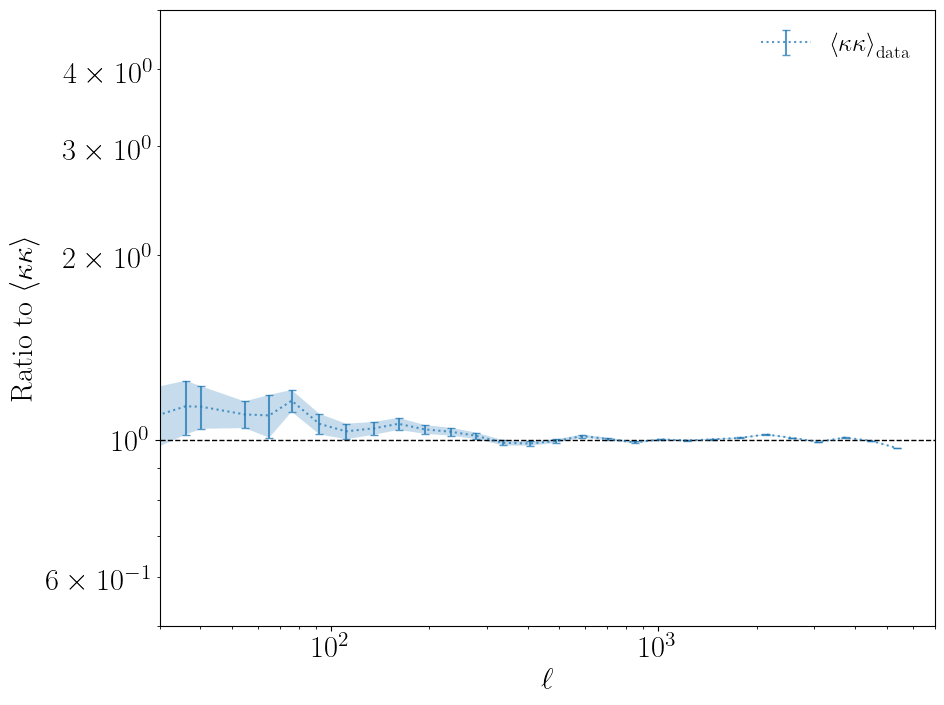

In [27]:
fig,ax = plt.subplots(nrows=1, figsize=(10,8))

c_keys = [
    'kk',
]

offsets = dict(zip(c_keys,[0,0.03]))
for key in c_keys:
    lCen, Cl, sCl = combine_Cl(np.array(ps_data[key]))
    
    kk_true = np.array([p2d_cmblens.fPinterp(l) for l in lCen])
    
    Cl /= kk_true
    sCl /= kk_true
    offset = offsets[key]
    tmp = [l*np.exp(offset)-l for l in lCen]
    lCen += tmp

    Ipos = np.where(Cl>=1e-30)
    
    ax.errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=.75, 
                fmt=':', capsize=3, capthick=1, label=labels[key])
    tmp_data = {
        'x': lCen[Ipos],
        'y1': [y - e for y, e in zip((Cl[Ipos]), sCl[Ipos])],
        'y2': [y + e for y, e in zip((Cl[Ipos]), sCl[Ipos])]}
    ax.fill_between(**tmp_data,  alpha=.25)


ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel(r'Ratio to $\left<\kappa\kappa\right>$')

ax.set_xlabel(r'$\ell$')
ax.set_xlim(lMin,2*lMax)
ax.set_ylim(0.5,5)
plt.axhline(1, linewidth=1, linestyle="--", color="black")
plt.savefig('figures/kk_data_over_kk.pdf', bbox_inches='tight')

100 (100, 3, 50)


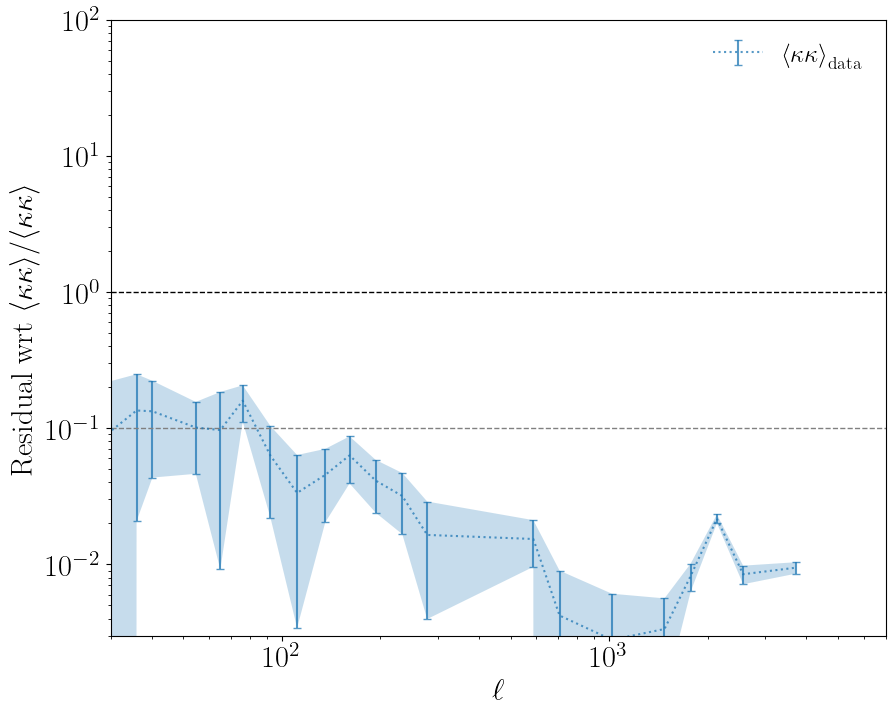

In [28]:
fig,ax = plt.subplots(nrows=1, figsize=(10,8))

c_keys = [
    'kk'
]

offsets = dict(zip(c_keys,[0,0.03]))
for key in c_keys:
    lCen, Cl, sCl = combine_Cl(np.array(ps_data[key]))
    
    kk_true = np.array([p2d_cmblens.fPinterp(l) for l in lCen])
    
    Cl -= kk_true
    Cl /= kk_true
    sCl /= kk_true
    
    offset = offsets[key]
    tmp = [l*np.exp(offset)-l for l in lCen]
    lCen += tmp

    Ipos = np.where(Cl>=1e-30)
    Ineg = np.where(Cl<=-1e-30)
    
    ax.errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=.75, 
                fmt=':', capsize=3, capthick=1, label=labels[key])
        
    tmp_data = {
        'x': lCen[Ipos],
        'y1': [y - e for y, e in zip((Cl[Ipos]), sCl[Ipos])],
        'y2': [y + e for y, e in zip((Cl[Ipos]), sCl[Ipos])]}
    ax.fill_between(**tmp_data,  alpha=.25)
    


ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_ylabel(r'Residual wrt $\left<\kappa\kappa\right>$/$\left<\kappa\kappa\right>$')

# ax.set_yscale(matplotlib.scale.SymmetricalLogScale(ax, linthresh=1e-10))
ax.set_yscale('log')


ax.set_xlabel(r'$\ell$')
ax.set_xlim(lMin,2*lMax)
ax.set_ylim(.3e-2,1e2)
plt.axhline(1, linewidth=1, linestyle="--", color="black")
plt.axhline(.1, linewidth=1, linestyle="--", color="gray")

plt.savefig('figures/kk_residual.pdf', bbox_inches='tight')

In [100]:
#bandaid
lCen, Cl, sCl = combine_Cl(np.array(ps_data[key]))
ll = ['%d'%l for l in lCen]
#
def corr2(corr_nhat1, 
          corr_nhat2, 
          filename_base, 
          cmap='seismic', 
          cmap2='seismic', 
          label='', 
          label2=''):
    
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['text.usetex'] = True

    plt.rcParams['font.size'] = 26
    plt.rcParams['text.latex.preamble'] = r'\usepackage{xcolor}'
    plt.rcParams['text.latex.preamble'] +='\n'
#     plt.rcParams['text.latex.preamble'] += r'\definecolor{c1}{rgb}{%.1f,%.1f,%.1f}'%(cmap[3][0],cmap[3][1],cmap[3][2])
#     plt.rcParams['text.latex.preamble'] +='\n'
#     plt.rcParams['text.latex.preamble'] +=r'\definecolor{c2}{rgb}{%.1f,%.1f,%.1f}'%(cmap2[3][0],cmap2[3][1],cmap2[3][2])

    
    corr_nhat = np.copy(corr_nhat1)
    sze = len(corr_nhat1)
    mask = np.array([[0 for _ in range(sze)] for _ in range(sze)])
    for i in range(sze-1):
        for j in range(sze-1-i):
            corr_nhat[i][sze-j-1] = corr_nhat2[i][sze-j-1]
            mask[i][sze-j-1] = 1
    plt.figure(figsize=(25,20))
    print(np.shape(corr_nhat))
    print(np.shape(mask))
    
    ax = sns.heatmap(corr_nhat,  cmap=cmap, cbar=True, vmin=-1, vmax=1, square=True,
                    cbar_kws={ 'ticks':[],
                              "orientation": "horizontal", 'pad':-0.17, 'shrink':0.3})
    
    sns.heatmap(corr_nhat, mask=mask, cmap=cmap2, cbar=True, ax=ax, vmin=-1, vmax=1,square=True,label=label,
           cbar_kws={'label': r"$|\rho|$","orientation": "horizontal", 'pad':0.1,  'shrink':0.3})
    

    ax.tick_params(axis=u'x', which=u'both',labelrotation=90)
    ax.set_xticks(np.arange(len(ll))+0.5, labels=ll)
    plt.xlabel(r'$\ell$'+'\n')

#     ax.legend(frameon=False)

    ax.tick_params(axis=u'y', which=u'both',labelrotation=0)
    ax.set_yticks(np.arange(len(ll))+0.5, labels=ll)
    plt.ylabel(r'$\ell$'+'\n')

    plt.title(r'Correlations for {%s} (Blue) and {%s} (Purple)'%(label, label2))
    plt.xlim(19, len(ll)-1)
    plt.ylim(19, len(ll)-1)

    plt.savefig('figures/corr_%s.pdf'%(filename_base), bbox_inches='tight')#, use='pgf')


100 (100, 3, 50)


In [101]:
for key in ps_data:
    print(key)

N0
kk
N1
QEQE
Nhat
N2+
N1+
KK+N1+
QEQE-Nhat


In [102]:
def corr_gen(keys, filename_base):
    Cls_tmp = np.array([None, None])
    for key,idx in zip(keys, range(2)):
        print(np.shape(ps_data[key]))
        Cls_tmp[idx] = np.transpose(np.copy(np.array(ps_data[key])), axes=[1,2,0])[1]

    corrs = np.array([[[(np.corrcoef(Cls_tmp[i][i1], Cls_tmp[i][i2])[1,0])
                          for i1 in range(len(Cls_tmp[i]))]
                         for i2 in range(len(Cls_tmp[i]))]
                         for i in range(2)])

    corr2(corrs[0], corrs[1], 
          label= labels[keys[0]],
         label2=labels[keys[1]], 
         filename_base=filename_base)

(100, 3, 50)
(100, 3, 50)
(50, 50)
(50, 50)


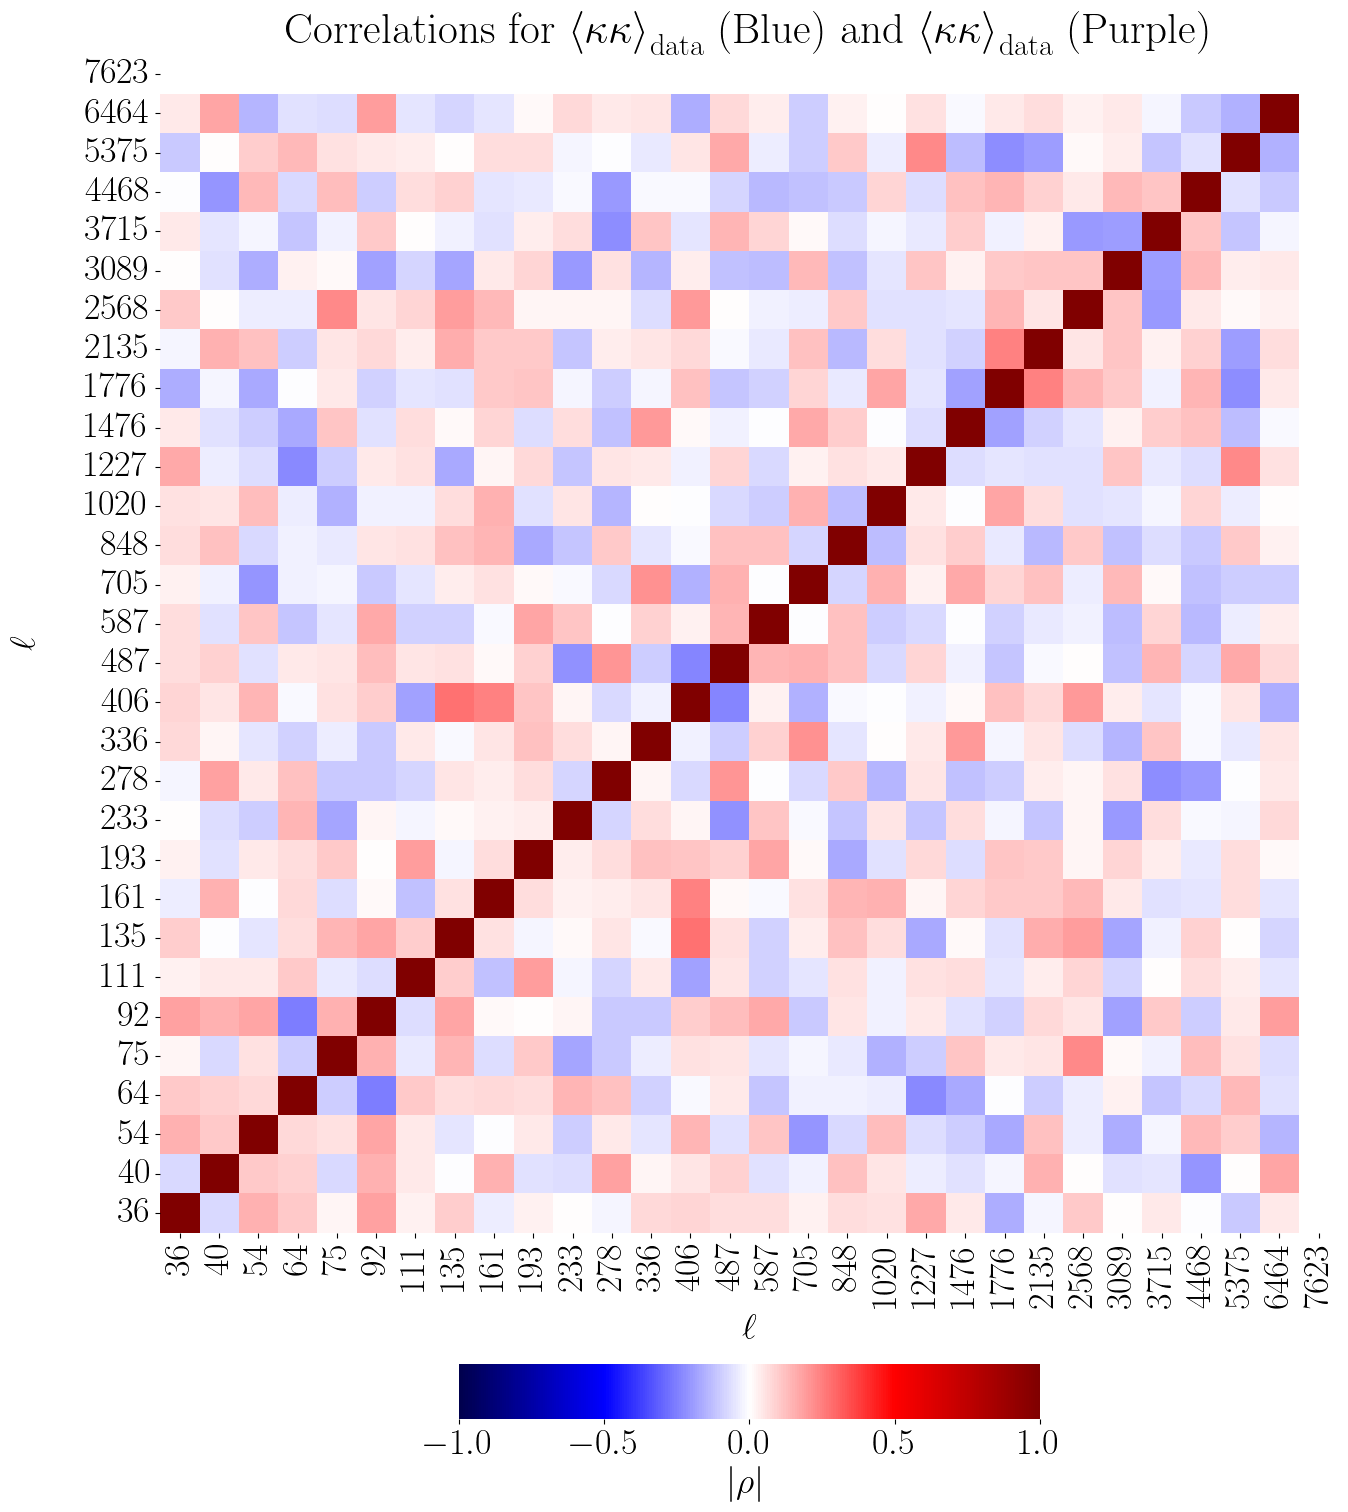

In [103]:
corr_gen(['kk', 'kk'], 'kk')

(100, 3, 50)
(100, 3, 50)
(50, 50)
(50, 50)


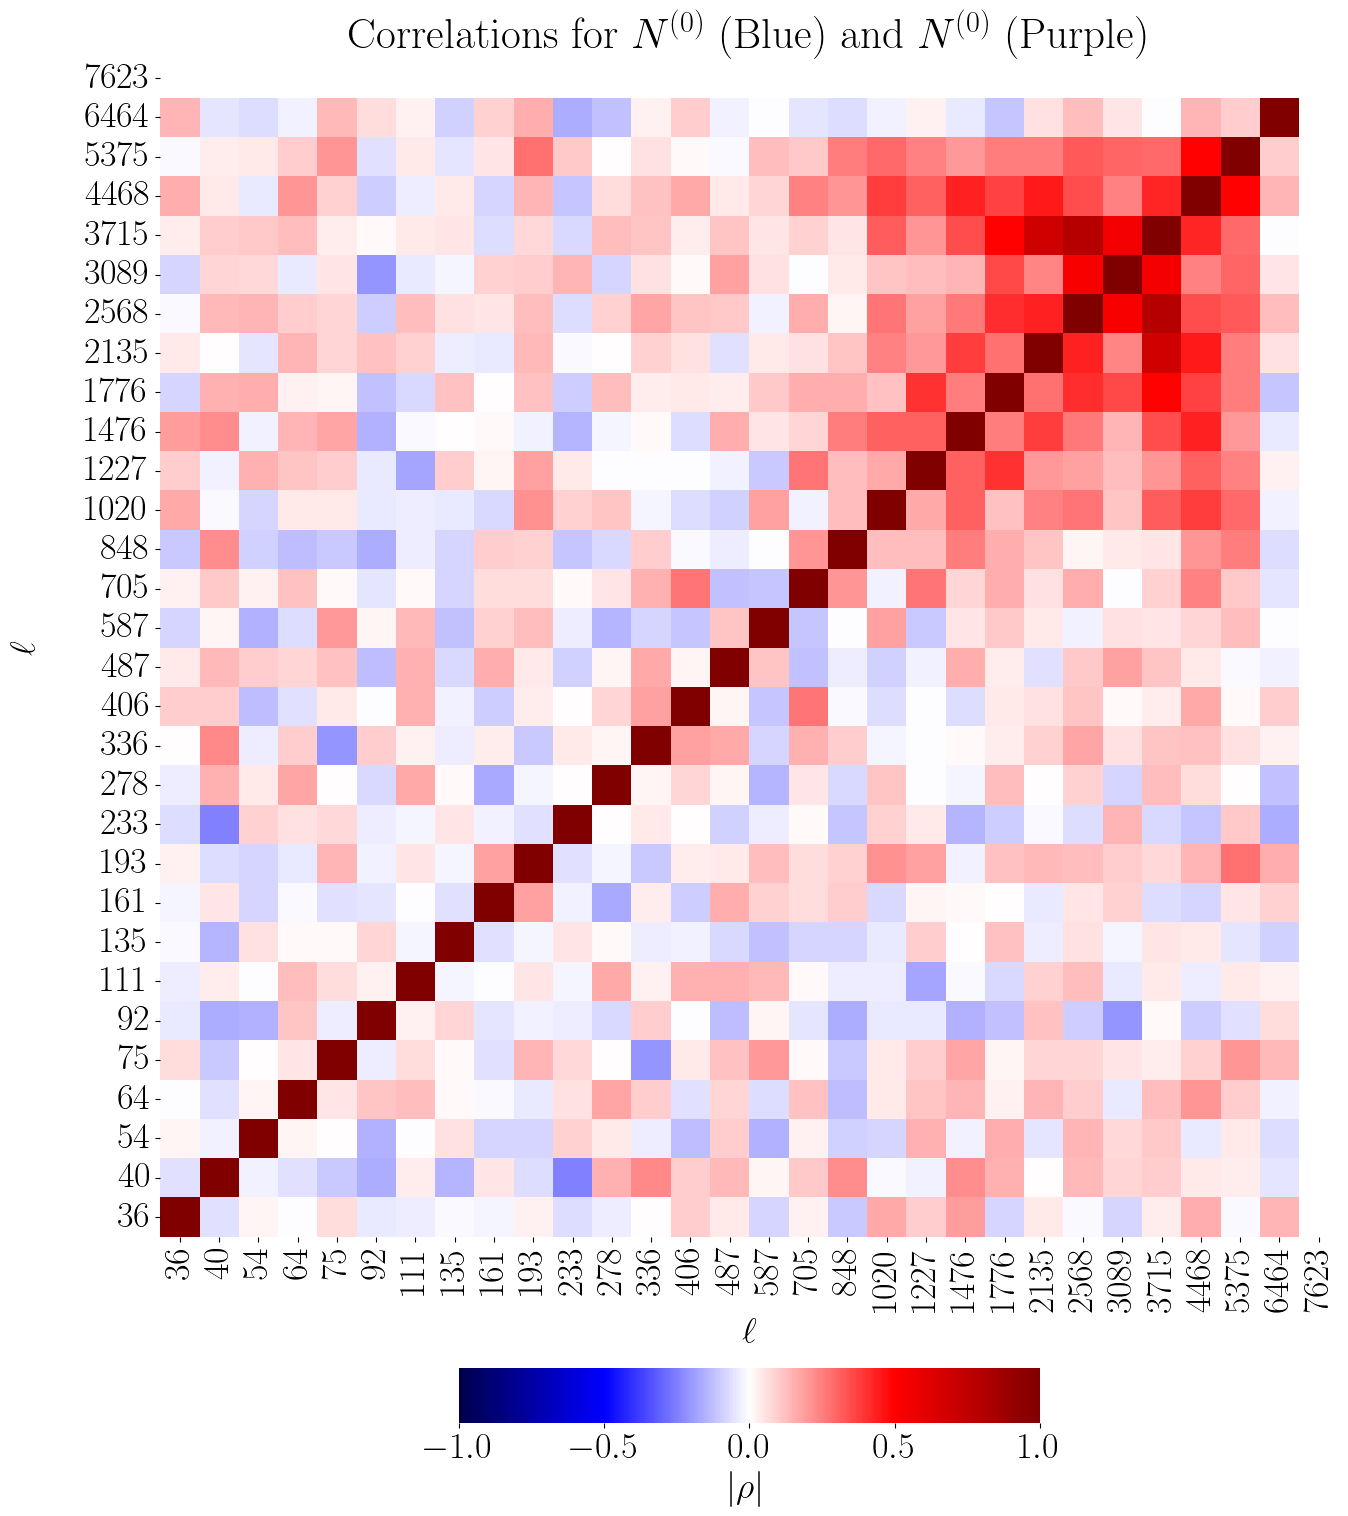

In [104]:
corr_gen(['N0', 'N0'], 'N0')

(100, 3, 50)
(100, 3, 50)
(50, 50)
(50, 50)


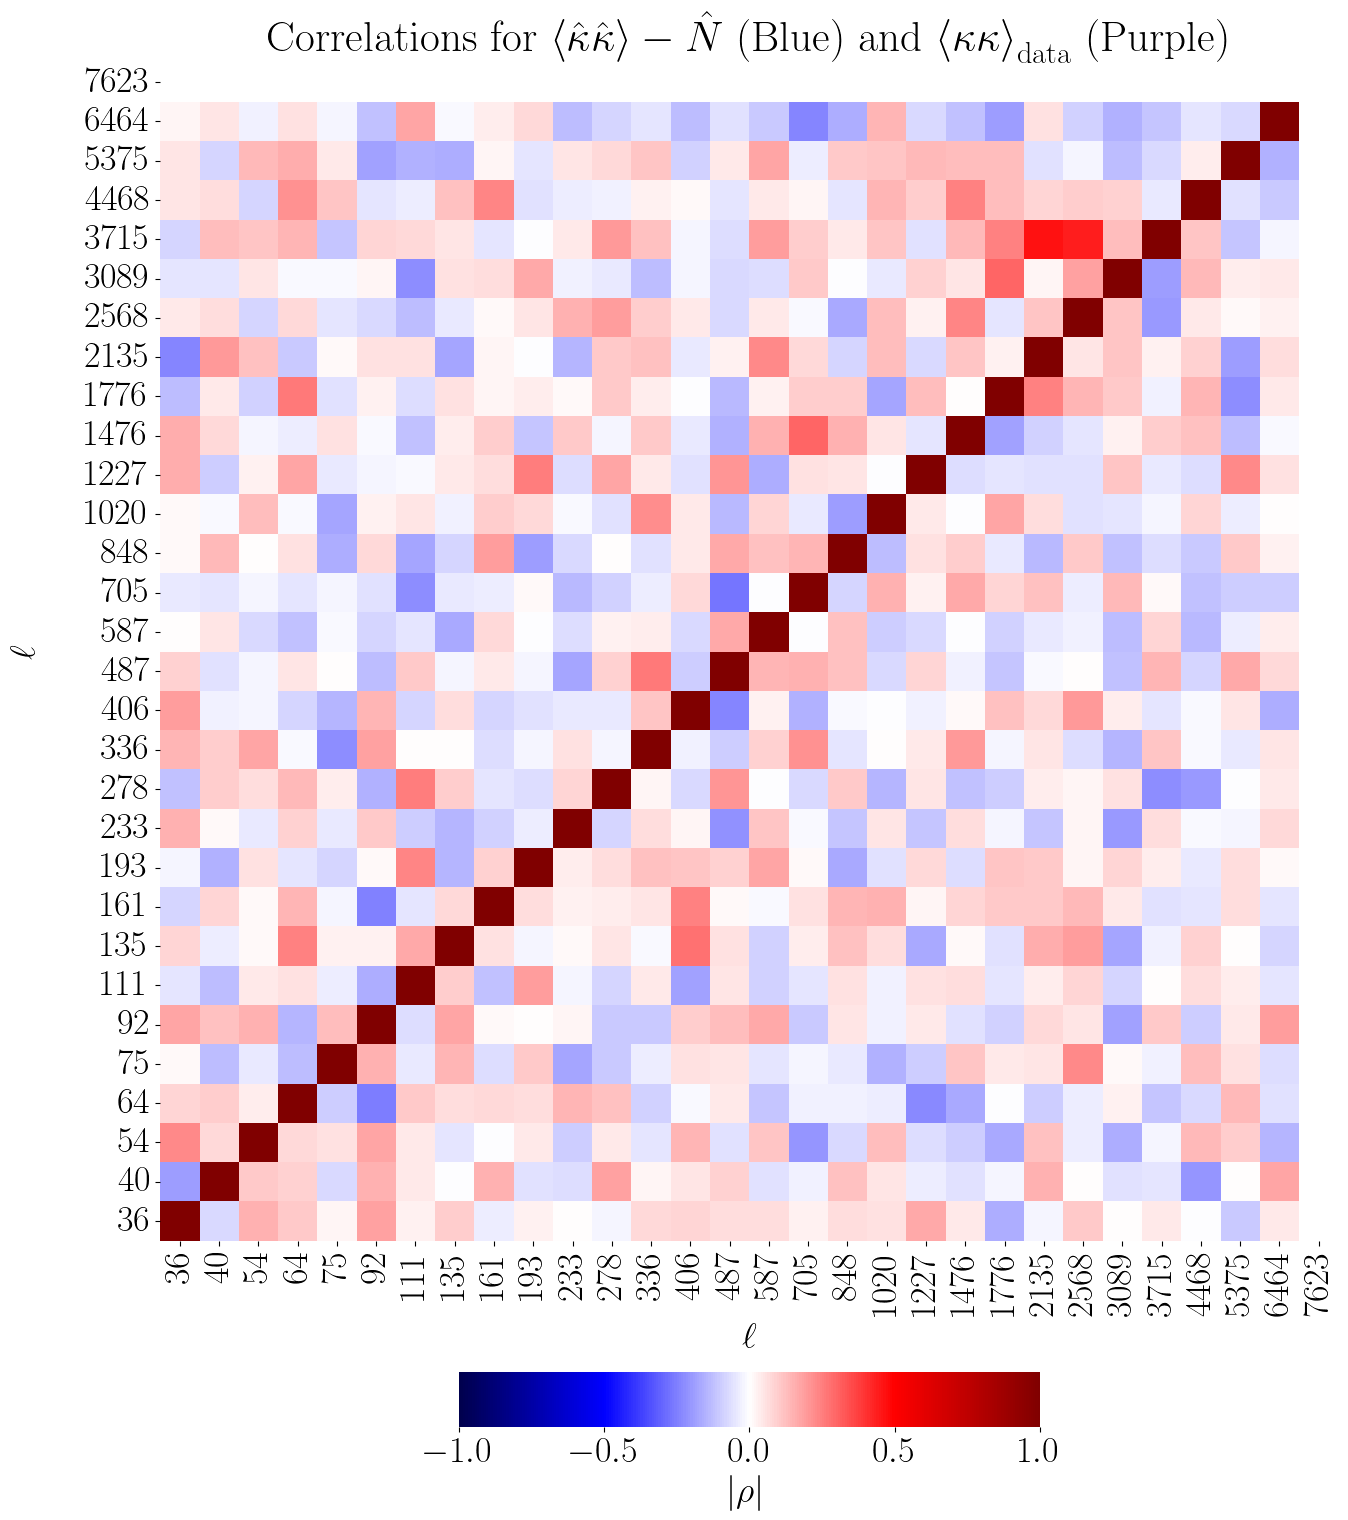

In [105]:
corr_gen(['QEQE-Nhat', 'kk'], 'QEQEmNhat_kk')

(100, 3, 50)
(100, 3, 50)
(50, 50)
(50, 50)


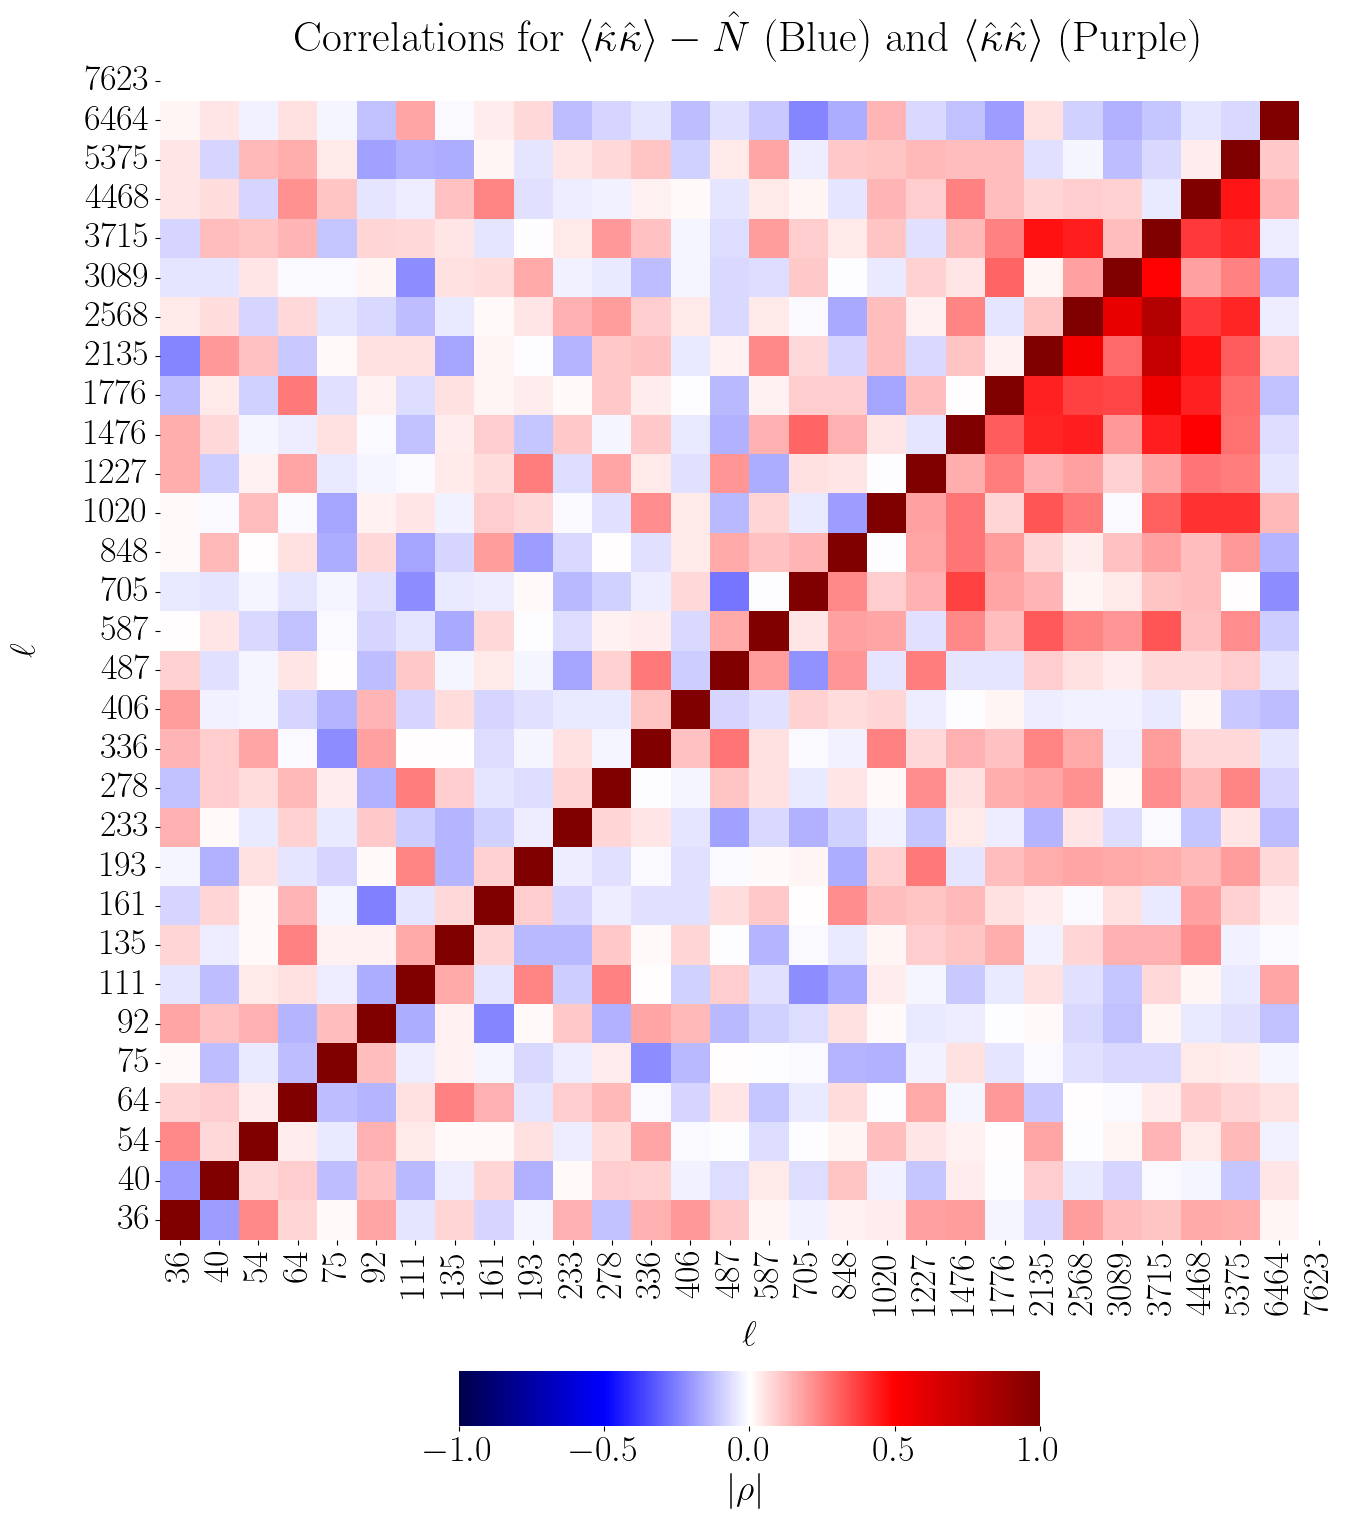

In [106]:
corr_gen(['QEQE-Nhat', 'QEQE'], 'QEQEmNhat_QEQE')

(100, 3, 50)
(100, 3, 50)
(50, 50)
(50, 50)


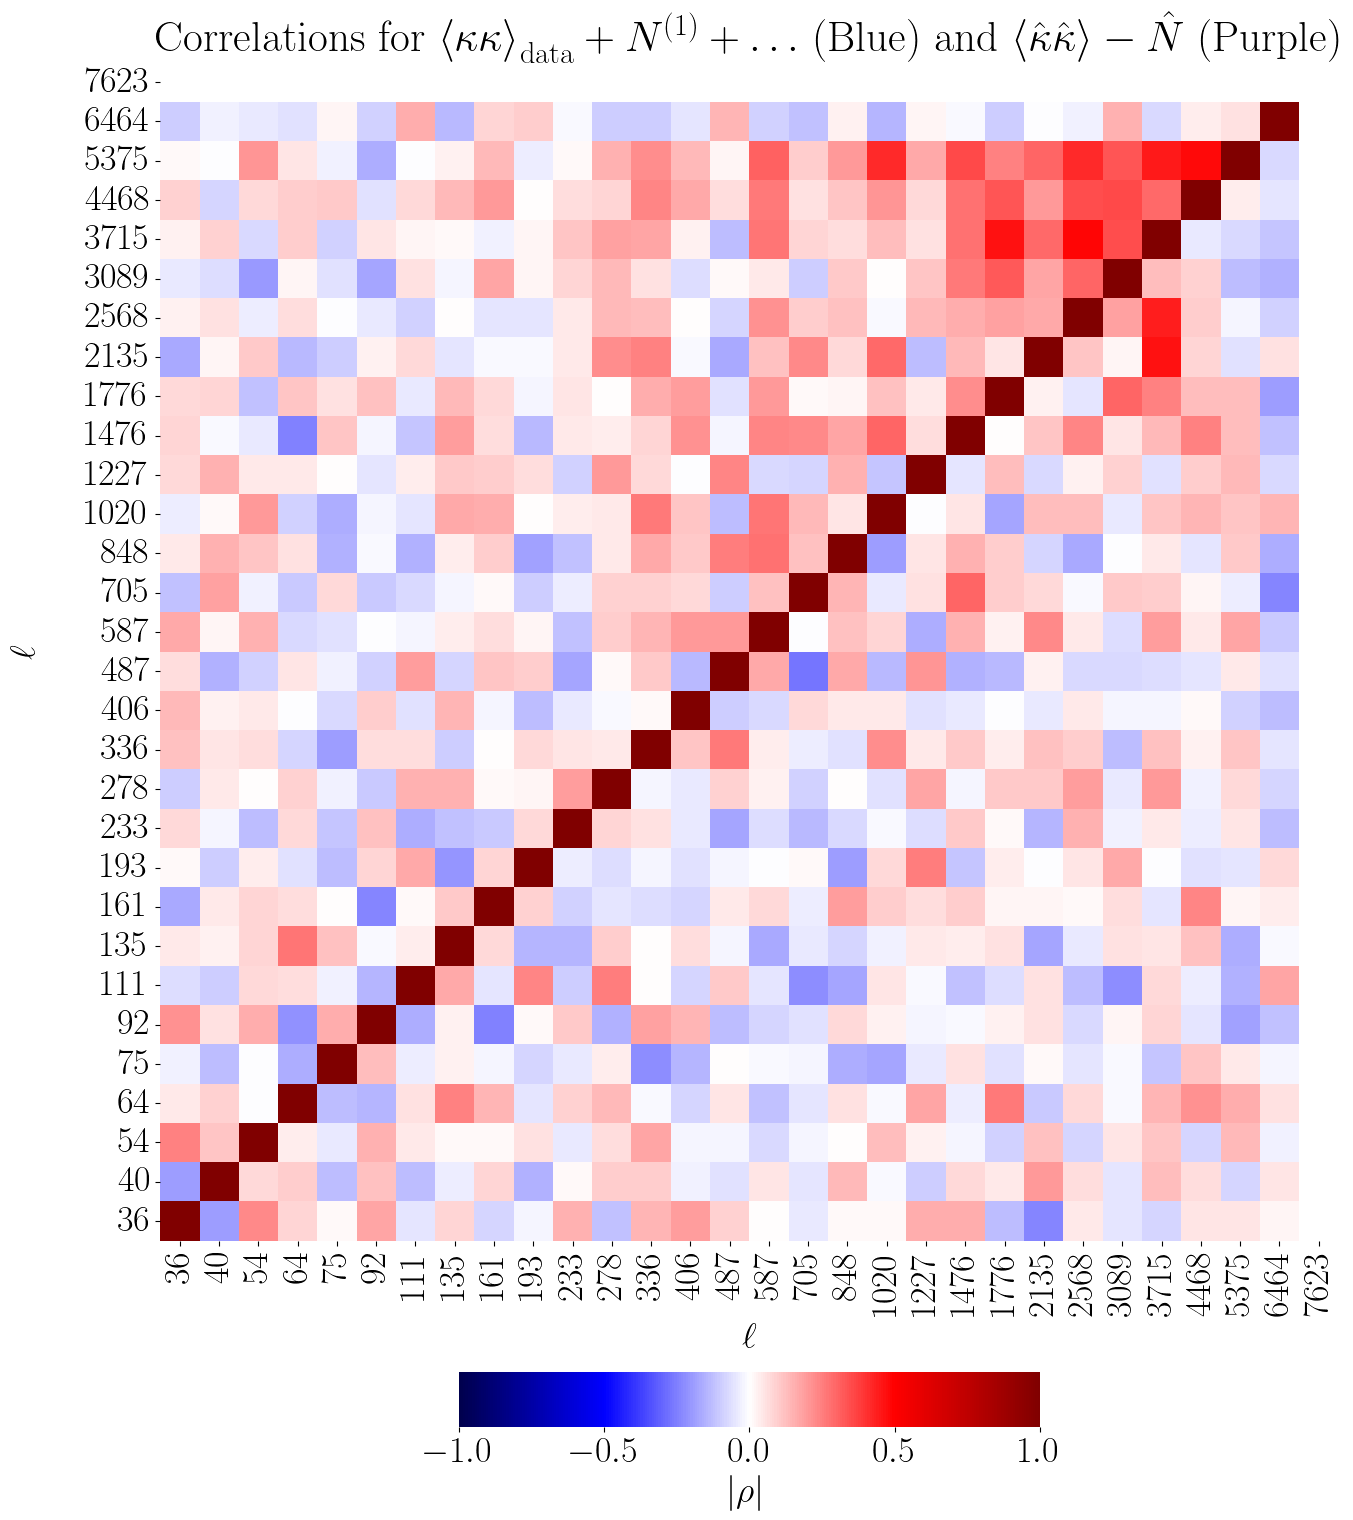

In [107]:
corr_gen(['KK+N1+', 'QEQE-Nhat'], 'KKpN1p_QEQEmNhat')

(100, 3, 50)
(100, 3, 50)
(50, 50)
(50, 50)


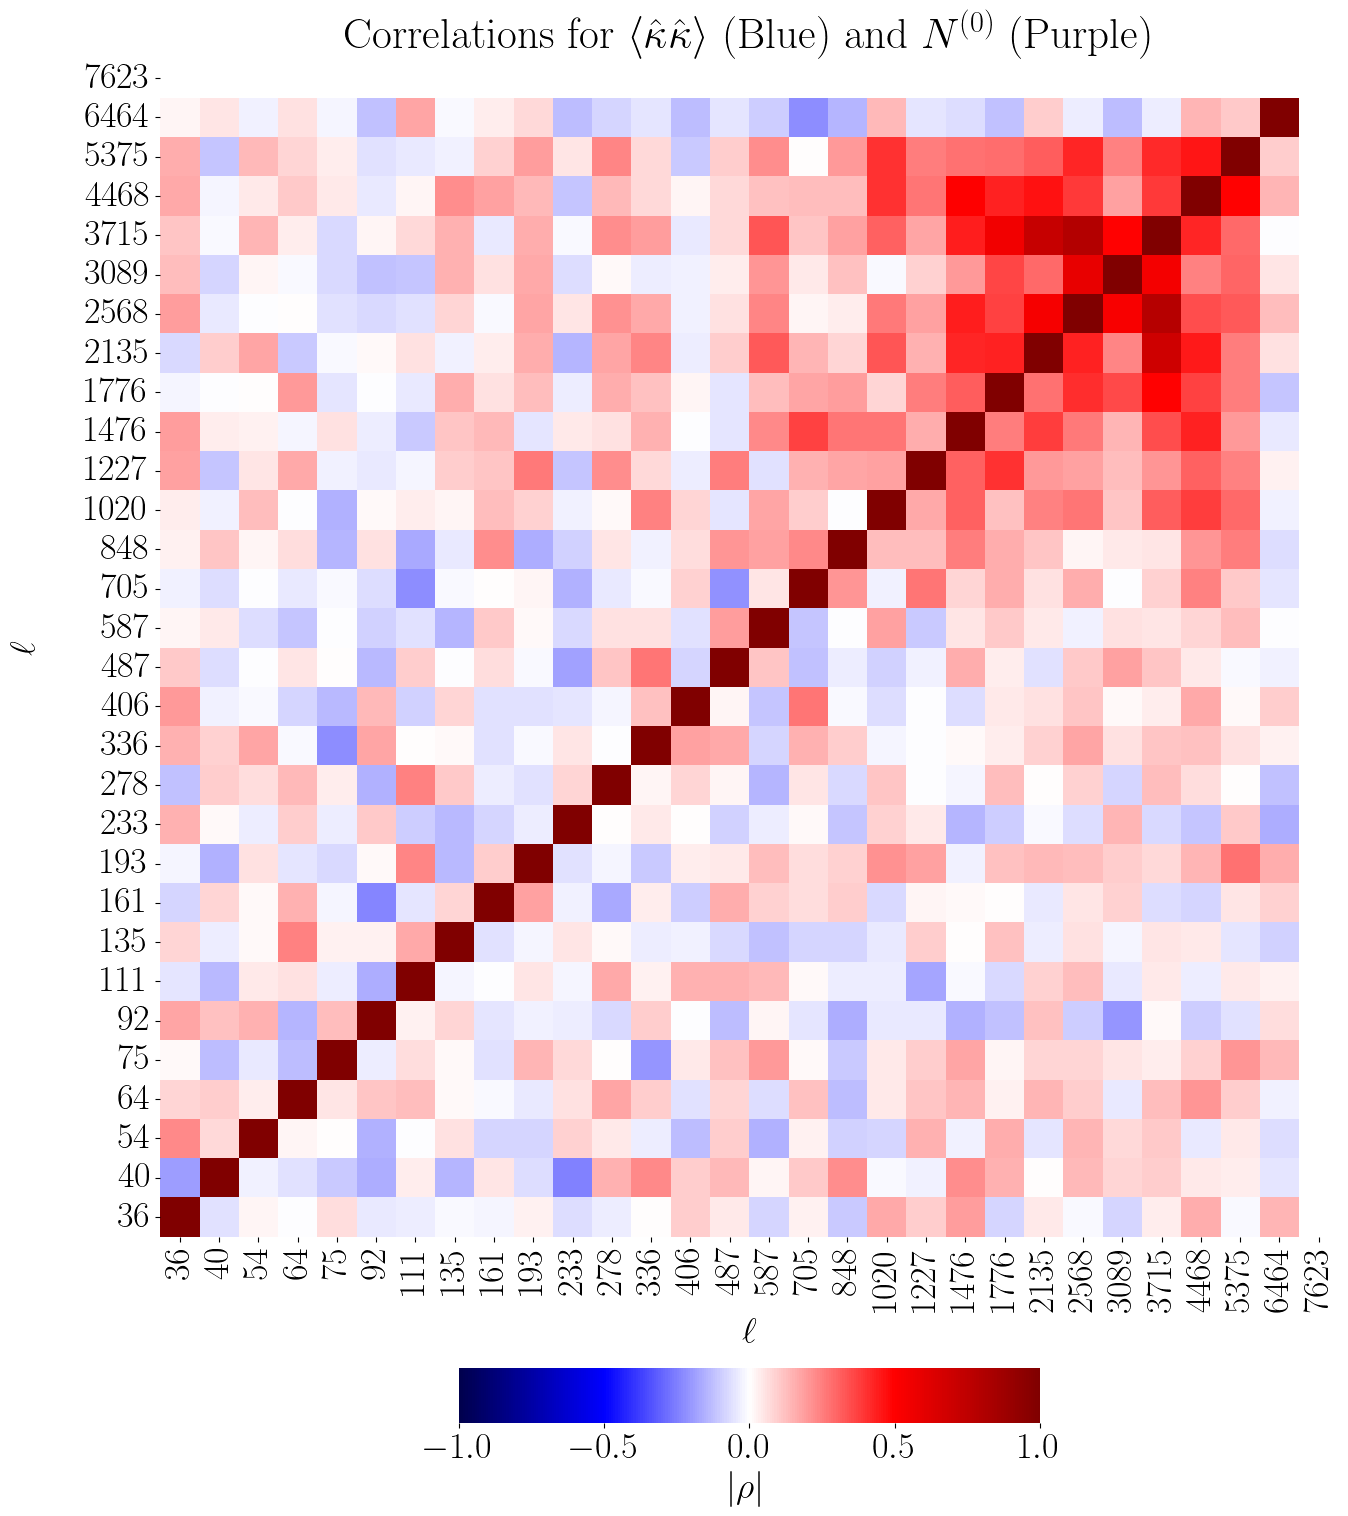

In [109]:
corr_gen(['QEQE', 'N0'], 'QEQE_N0')

(100, 3, 50)
(100, 3, 50)
(50, 50)
(50, 50)


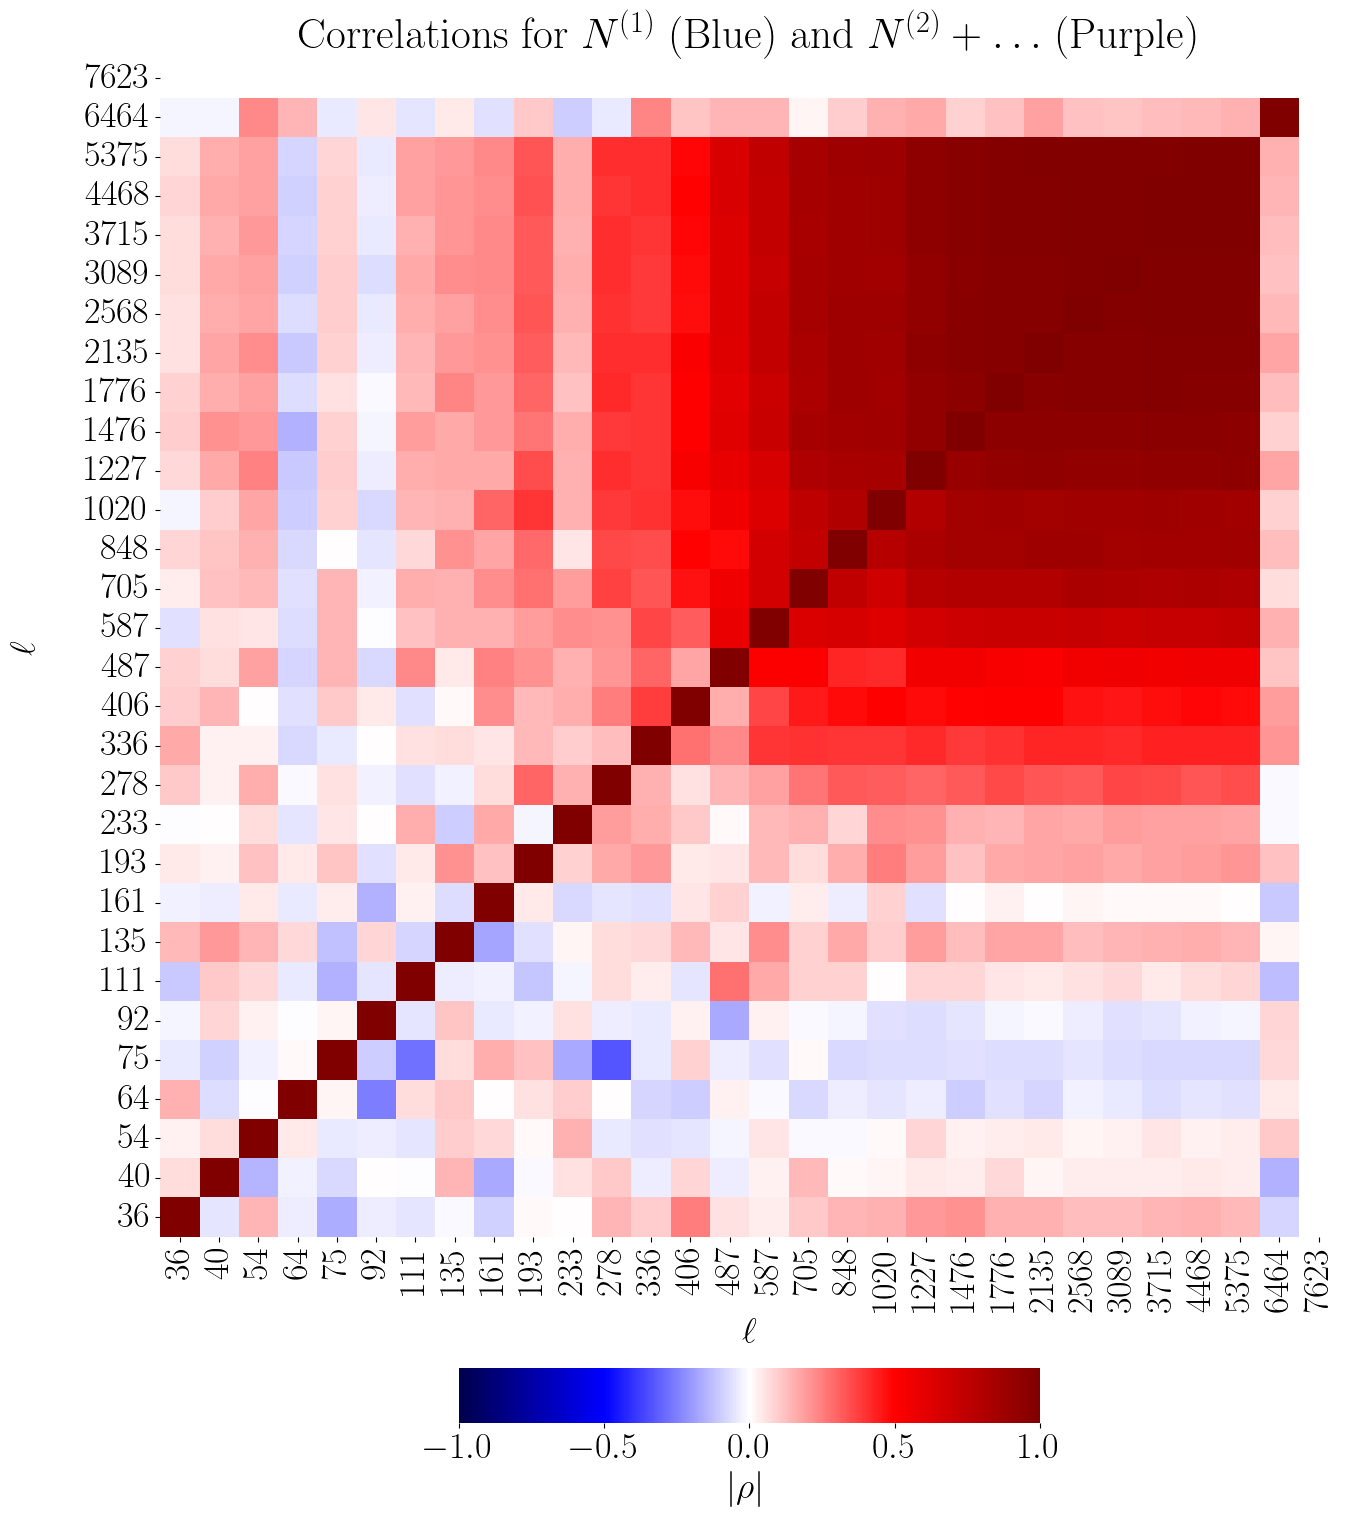

In [110]:
corr_gen(['N1', 'N2+'], 'N1_N2p')

(100, 3, 50)
(100, 3, 50)
(50, 50)
(50, 50)


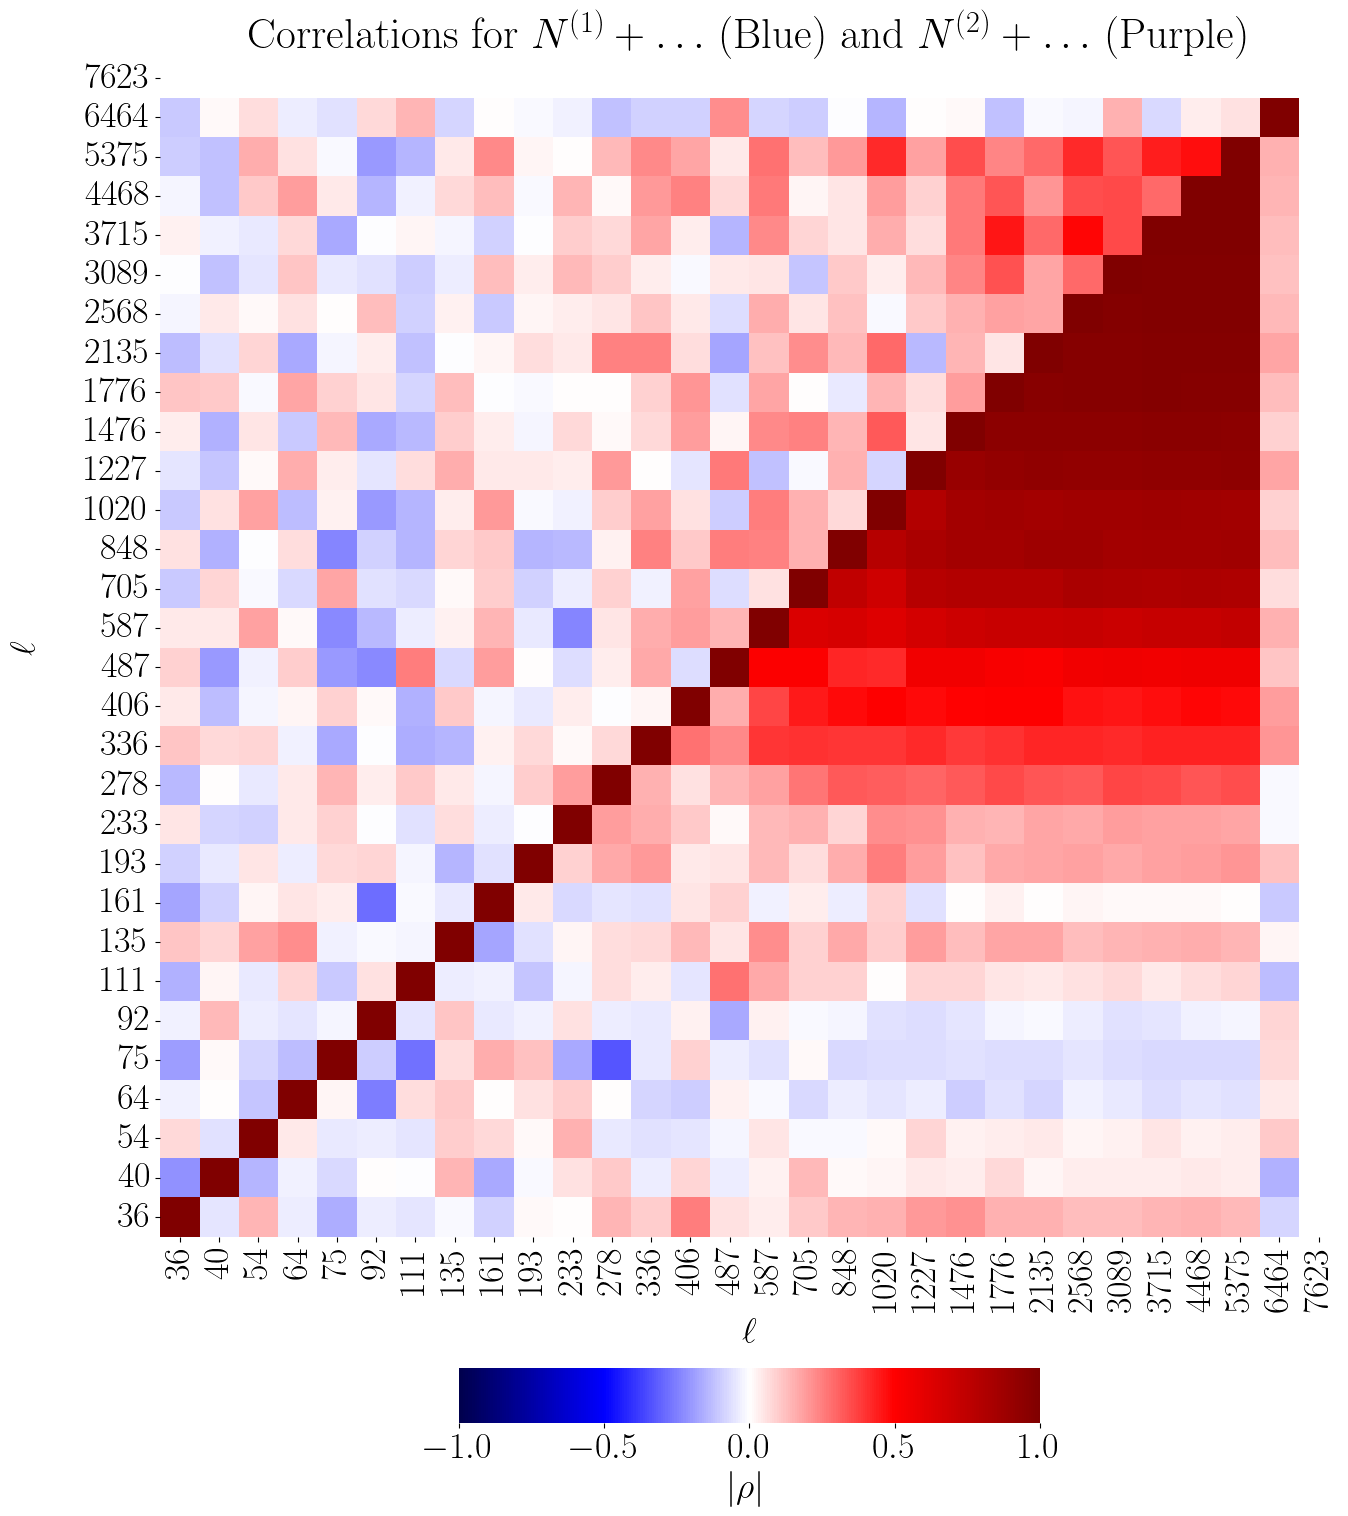

In [111]:
corr_gen(['N1+', 'N2+'], 'N1p_N2p')